In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    return node_features, edge_index, labels

In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

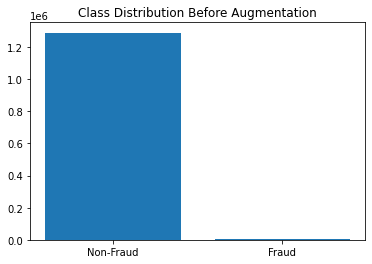

In [8]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
# Step 1: Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))
    
    def forward(self, node_features, edge_index):
        # Create adjacency matrix
        num_nodes = node_features.size(0)
        adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
        
        # Fill adjacency matrix
        for from_node, to_node in edge_index.T:
            adj[from_node.item(), to_node.item()] = 1
        
        # Normalize the adjacency matrix
        D = torch.diag(adj.sum(dim=1) ** -0.5)
        norm_adj = D @ adj @ D
        
        # Perform graph convolution
        out = norm_adj @ node_features @ self.weight
        return out

In [10]:
# Step 2: Update WGAN Generator and Discriminator
class WGANGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WGANGenerator, self).__init__()
        self.gcn1 = GCNLayer(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, z, edge_index, node_features):
        z = self.gcn1(node_features, edge_index)
        z = F.relu(z)
        return self.fc(z)

In [11]:
class WGANDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WGANDiscriminator, self).__init__()
        self.gcn1 = GCNLayer(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        return self.fc(x)

In [12]:
# WGAN parameters
input_size = node_features.shape[1]
hidden_size = 128
output_size = input_size
latent_size = 64

In [13]:
# Initialize WGAN components
generator = WGANGenerator(input_size, hidden_size, output_size)
discriminator = WGANDiscriminator(input_size, hidden_size)

In [14]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [15]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [16]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01])


In [17]:
# Training with early stopping
num_epochs = 1
target_minority_class = torch.sum(labels == 0)
real_data = node_features[labels == 1]

In [18]:
# Early stopping parameters
best_loss_d = float('inf')
patience = 1
trigger_times = 0

In [ ]:
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Update the discriminator 5 times for every generator update
    for _ in range(1):
        z = torch.randn(real_data.size(0), latent_size)
        fake_data = generator(z, edge_index, node_features)

        optimizer_d.zero_grad()
        d_real = discriminator(real_data, edge_index)
        d_fake = discriminator(fake_data.detach(), edge_index)
        loss_d = -torch.mean(d_real) + torch.mean(d_fake)
        loss_d.backward()
        optimizer_d.step()

        # Clip weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    optimizer_g.zero_grad()
    fake_data = generator(torch.randn(real_data.size(0), latent_size), edge_index, node_features)
    loss_g = -torch.mean(discriminator(fake_data, edge_index))
    loss_g.backward()
    optimizer_g.step()

    # Update labels based on newly generated samples
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    node_features = torch.cat((node_features, fake_data))

    # Early stopping check
    if loss_d.item() < best_loss_d:
        best_loss_d = loss_d.item()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered")
        break

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

In [ ]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size), edge_index, node_features)
y_generated = torch.ones(num_generated_samples, dtype=torch.long)

In [ ]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

In [ ]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation")

In [ ]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def plot_graph(node_features, edge_index, labels):
    G = nx.DiGraph()
    for i in range(node_features.shape[0]):
        G.add_node(i, features=node_features[i].detach().numpy(), label=labels[i].item())
    for from_node, to_node in edge_index.T:
        G.add_edge(from_node.item(), to_node.item())
    color_map = ['red' if G.nodes[node]['label'] == 1 else 'blue' for node in G.nodes()]
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=100, font_size=8, font_color='white', alpha=0.8)
    plt.title("Graph Dataset Visualization")
    plt.show()

In [ ]:
# Call the function with your graph data
plot_graph(node_features, edge_index, labels)